In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering


In [62]:
df = pd.read_csv("smartcart_customers.csv")

In [63]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,172,88,88,3,8,10,4,7,0,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,2,1,6,2,1,1,2,5,0,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,111,21,42,1,8,2,10,4,0,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,10,3,5,2,2,0,4,6,0,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,46,27,15,5,5,3,6,5,0,0


# Data Preprocessing

In [64]:
# handle missing values 
df.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
Complain                0
Response                0
dtype: int64

In [65]:
df['Income'] = df['Income'].fillna(df['Income'].median())


# Feature Engineering

In [66]:
#Age

df['Age'] = 2026-df['Year_Birth']

In [67]:
#Customer joining date

df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], dayfirst = True )

reference_date = df['Dt_Customer'].max()


df["Customer_Tenure_Days"] = (reference_date -df["Dt_Customer"]).dt.days

In [68]:
#Spending

df['Total_spending'] = df['MntWines']+df['MntFruits']+df['MntMeatProducts']+df['MntFishProducts']+df['MntSweetProducts']+df['MntGoldProds']

In [69]:
# children
df['Total_Children'] = df['Kidhome']+df['Teenhome']

In [70]:
# Eduction 

df['Education'].value_counts()
# Undergraduate , Graduate , PostGraduate

df['Education'] = df['Education'].replace({
    "Basic" : "Undergraduate","2n Cycle":"Undergraduate",
    "Graduation":"Graduate",
    "Master":"Postgraduate","PhD":"Postgraduate"
})



In [71]:
df['Living_with'] = df['Marital_Status'].replace({
    "Married" : "Partner","Together":"Partner",
    "Single":"Alone","Divorced":"Alone",
    "Widow":"Alone","Absurd":"Alone","YOLO":"Alone"
})

In [72]:
# Drop columns
df.head()


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response,Age,Customer_Tenure_Days,Total_spending,Total_Children,Living_with
0,5524,1957,Graduate,Single,58138.0,0,0,2012-09-04,58,635,...,10,4,7,0,1,69,663,1617,0,Alone
1,2174,1954,Graduate,Single,46344.0,1,1,2014-03-08,38,11,...,1,2,5,0,0,72,113,27,2,Alone
2,4141,1965,Graduate,Together,71613.0,0,0,2013-08-21,26,426,...,2,10,4,0,0,61,312,776,0,Partner
3,6182,1984,Graduate,Together,26646.0,1,0,2014-02-10,26,11,...,0,4,6,0,0,42,139,53,1,Partner
4,5324,1981,Postgraduate,Married,58293.0,1,0,2014-01-19,94,173,...,3,6,5,0,0,45,161,422,1,Partner


In [107]:
cols = ['ID','Year_Birth','Marital_Status','Kidhome','Teenhome','Dt_Customer']
spending_cols = ['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']

cols_to_drop = cols+spending_cols

df_cleaned = df.drop(columns=cols_to_drop)

# Outliers

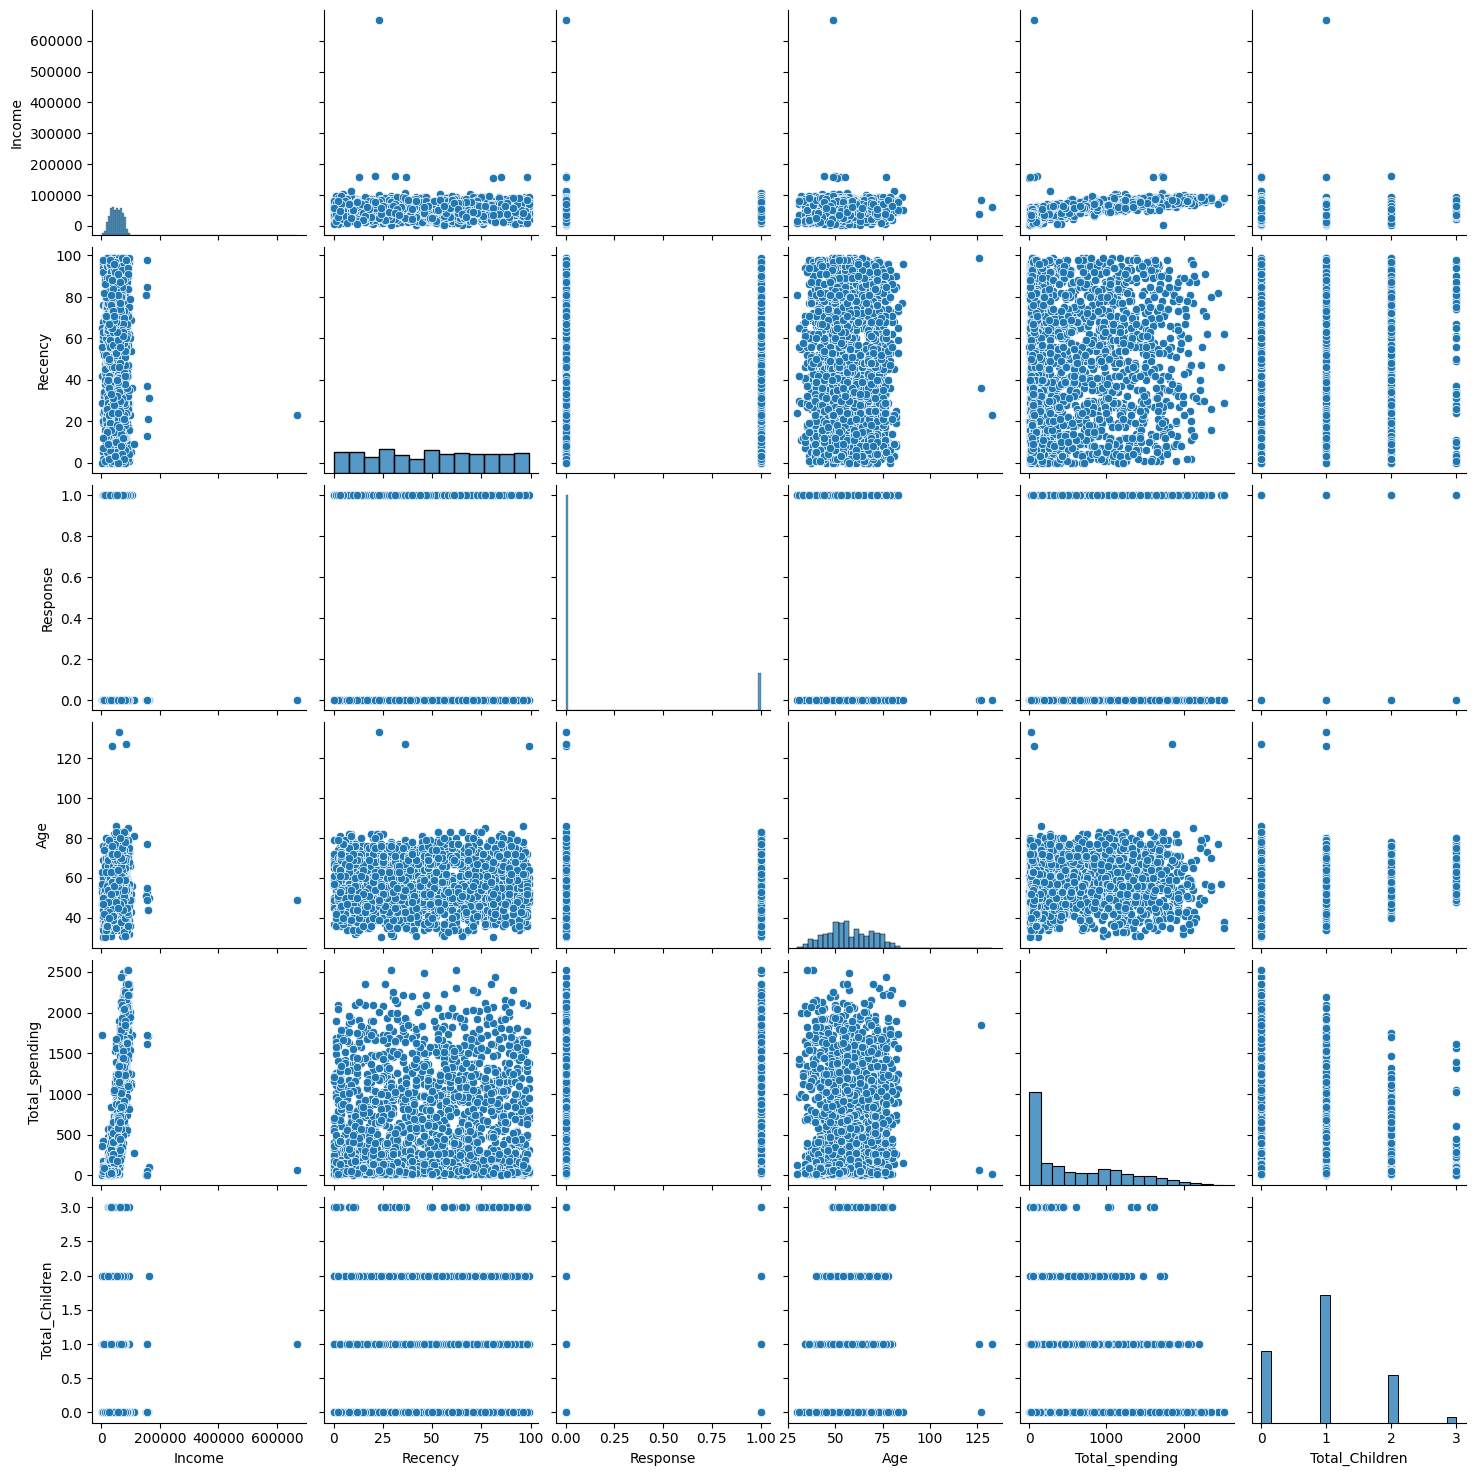

In [108]:
cols = ["Income","Recency","Response","Age","Total_spending","Total_Children"]
sns.pairplot(df_cleaned[cols])

In [109]:
# Remove the outliers 

df_cleaned = df_cleaned[(df_cleaned["Age"]<90)]
df_cleaned = df_cleaned[(df_cleaned["Income"]<600_000)]

# Heatmap

In [110]:
corr = df_cleaned.corr(numeric_only=True)

<Axes: >

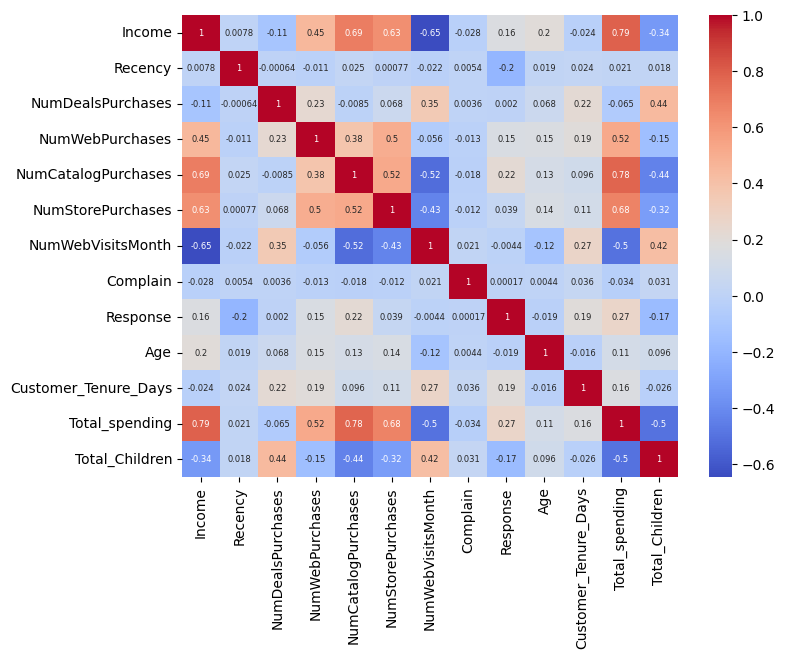

In [111]:
plt.figure(figsize=(8,6))

sns.heatmap(
    corr,
    annot=True,
    annot_kws={"size":6},
    cmap="coolwarm"
)

In [112]:
# Encoding

ohe = OneHotEncoder()

cat_cols = ["Education","Living_with"]

enc_cols = ohe.fit_transform(df_cleaned[cat_cols])

In [113]:
enc_df =pd.DataFrame(enc_cols.toarray(),columns=ohe.get_feature_names_out(cat_cols),index=df_cleaned.index)

In [114]:
df_encoded = pd.concat([df_cleaned.drop(columns=cat_cols),enc_df],axis=1)

In [115]:
#scaling

X = df_encoded

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Visualize

In [117]:
pca = PCA(n_components=3)

X_pca = pca.fit_transform(X_scaled)

In [118]:
pca.explained_variance_ratio_

array([0.23163158, 0.11385454, 0.10405815])

Text(0.5, 0.92, '3d projection')

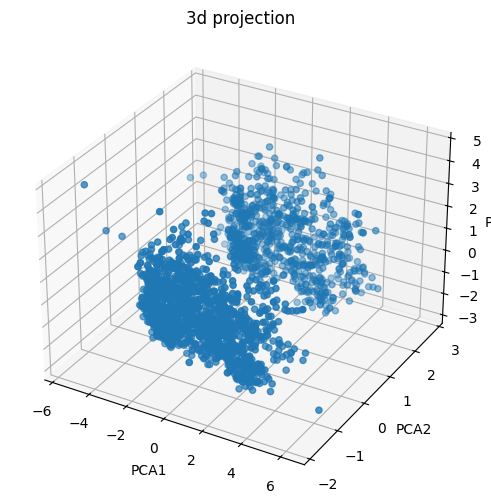

In [119]:
#PCA 
fig= plt.figure(figsize = (8,6))
ax = fig.add_subplot(111,projection="3d")

ax.scatter(X_pca[:,0],X_pca[:,1],X_pca[:,2])

ax.set_xlabel("PCA1")
ax.set_ylabel("PCA2")
ax.set_zlabel("PCA3")
ax.set_title("3d projection")

# Analyze K value

In [121]:
wcss = []

for k in range(1,11):
    kmeans = KMeans(n_clusters=k , random_state=42)
    kmeans.fit_predict(X_pca)
    wcss.append(kmeans.inertia_)

In [122]:
knee = KneeLocator(range(1,11),wcss, curve="convex",direction="decreasing")
optimal_k = knee.elbow

Text(0, 0.5, 'WCSS')

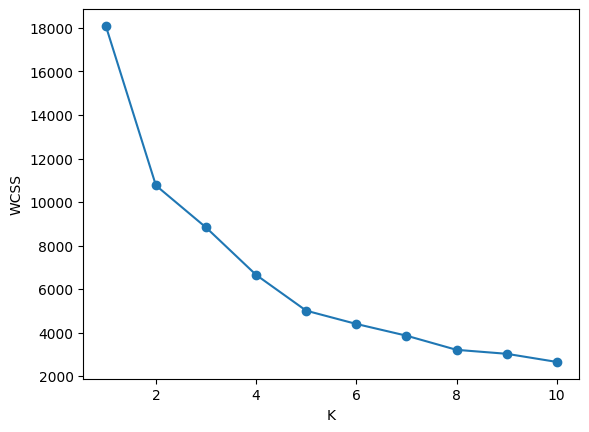

In [123]:
#Plot

plt.plot(range(1,11),wcss,marker = "o")
plt.xlabel("K")
plt.ylabel("WCSS")

# Silhouette Score

Text(0, 0.5, 'Silhouette Score')

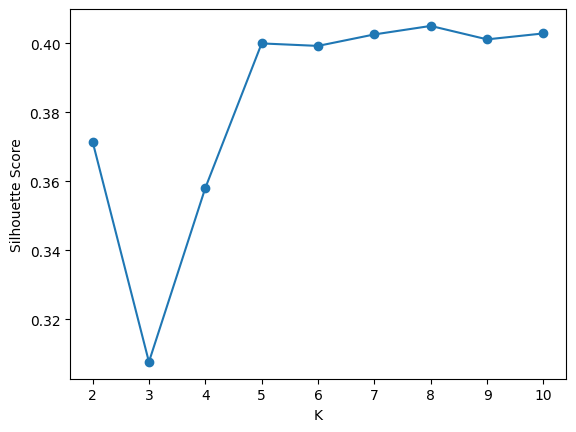

In [124]:
scores =[]

for k in range(2,11):
    kmeans = KMeans(n_clusters=k , random_state=42)
    labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca,labels)
    scores.append(score)

    #Plot
plt.plot(range(2,11),scores,marker = "o")
plt.xlabel("K")
plt.ylabel("Silhouette Score")

Text(0, 0.5, 'SS')

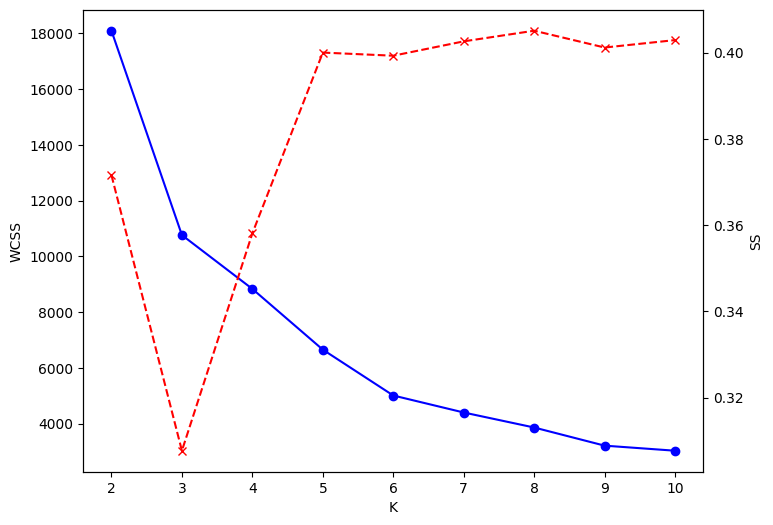

In [125]:
# combined plot

k_range = range(2, 11)

fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.plot(k_range, wcss[:len(k_range)], marker="o", color="blue") 
ax1.set_xlabel("K")
ax1.set_ylabel("WCSS")

ax2 = ax1.twinx()
ax2.plot(k_range, scores[:len(k_range)], marker="x", color="red", linestyle="--")
ax2.set_ylabel("SS")

In [126]:
#Clustering

#K_means

kmeans = KMeans(
    n_clusters=4,
    random_state=42
)

labels_kmeans = kmeans.fit_predict(X_pca)

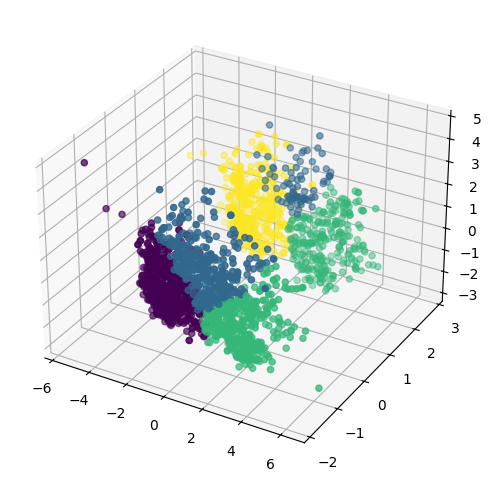

In [127]:
fig= plt.figure(figsize = (8,6))
ax = fig.add_subplot(111,projection="3d")

ax.scatter(X_pca[:,0],X_pca[:,1],X_pca[:,2],c=labels_kmeans)

In [128]:
#Agglomerative Clustering

agg_clf = AgglomerativeClustering(n_clusters=4 , linkage="ward")
labels_agg = agg_clf.fit_predict(X_pca)

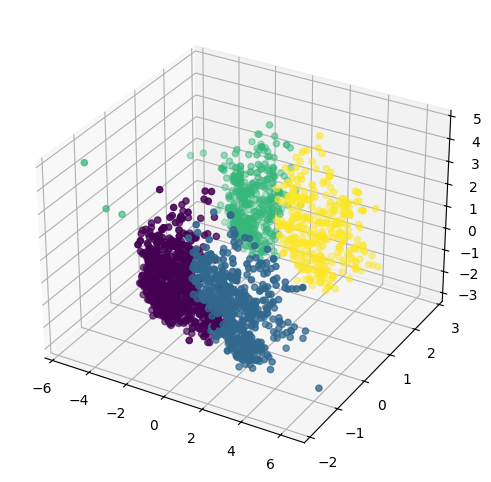

In [129]:
fig= plt.figure(figsize = (8,6))
ax = fig.add_subplot(111,projection="3d")

ax.scatter(X_pca[:,0],X_pca[:,1],X_pca[:,2],c=labels_agg)

# Characterization of Clusters

In [141]:

X["cluster"] = labels_agg

<Axes: xlabel='cluster', ylabel='count'>

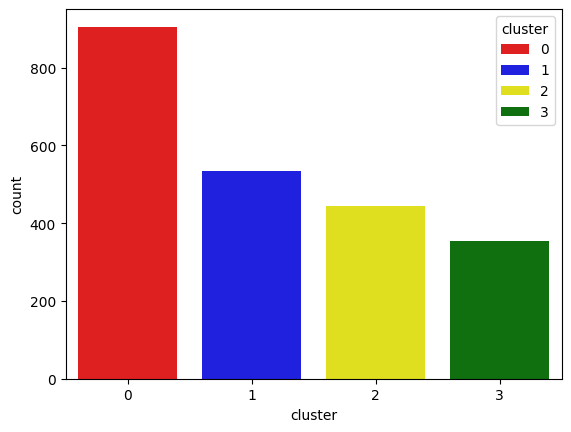

In [142]:
pal = ["red", "blue", "yellow", "green"]

sns.countplot(x=X["cluster"], palette=pal, hue=X["cluster"])

<Axes: xlabel='Total_spending', ylabel='Income'>

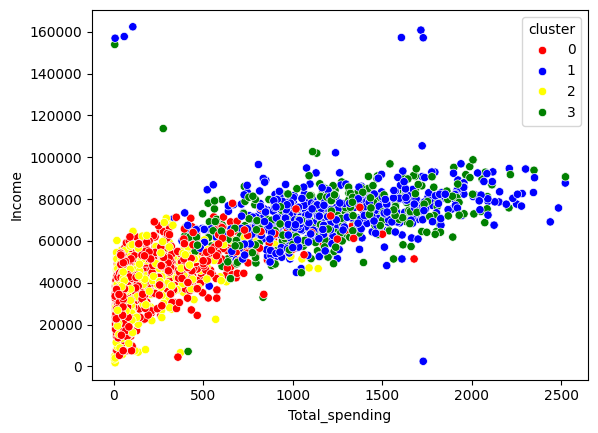

In [143]:
# Income & Spending patterns

sns.scatterplot(x=X["Total_spending"], y=X["Income"], hue=X["cluster"], palette=pal)

In [140]:
# Cluster Summary

cluster_summary = X.groupby("cluster").mean()
print(cluster_summary)

               Income    Recency  NumDealsPurchases  NumWebPurchases  \
cluster                                                                
0        39680.580110  48.914917           2.594475         3.153591   
1        72808.445693  49.202247           1.958801         5.687266   
2        36960.143018  48.319820           2.594595         2.713964   
3        70722.681303  50.504249           1.855524         5.790368   

         NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  Complain  \
cluster                                                                        
0                   0.969061           4.143646           6.307182  0.011050   
1                   5.498127           8.659176           3.580524  0.005618   
2                   0.837838           3.623874           6.659910  0.011261   
3                   5.014164           8.430595           3.728045  0.005666   

         Response        Age  Customer_Tenure_Days  Total_spending  \
cluster         